In [64]:
# 数据处理及可视化
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LinearRegression, Lasso, Ridge, ElasticNet
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.tree import DecisionTreeRegressor
%matplotlib inline
from sklearn.kernel_ridge import KernelRidge
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.preprocessing import RobustScaler, StandardScaler,MinMaxScaler
from sklearn.base import BaseEstimator, TransformerMixin, RegressorMixin, clone
from sklearn.model_selection import KFold, cross_val_score, train_test_split
from sklearn.metrics import mean_squared_error
import xgboost
import lightgbm
from scipy import stats
from scipy.stats import skew
# pd.set_option('display.max_rows', None)
# pd.set_option('display.max_columns', None)

In [65]:
# 获取训练数据与测试数据
train = pd.read_csv("/Users/ed/Downloads/house-prices-advanced-regression-techniques/train.csv")
test = pd.read_csv("/Users/ed/Downloads/house-prices-advanced-regression-techniques/test.csv")
sample_submission = pd.read_csv("/Users/ed/Downloads/house-prices-advanced-regression-techniques/sample_submission.csv")

In [66]:
train.shape,test.shape

((1460, 81), (1459, 80))

In [67]:
train.dtypes

Id                 int64
MSSubClass         int64
MSZoning          object
LotFrontage      float64
LotArea            int64
                  ...   
MoSold             int64
YrSold             int64
SaleType          object
SaleCondition     object
SalePrice          int64
Length: 81, dtype: object

<AxesSubplot:>

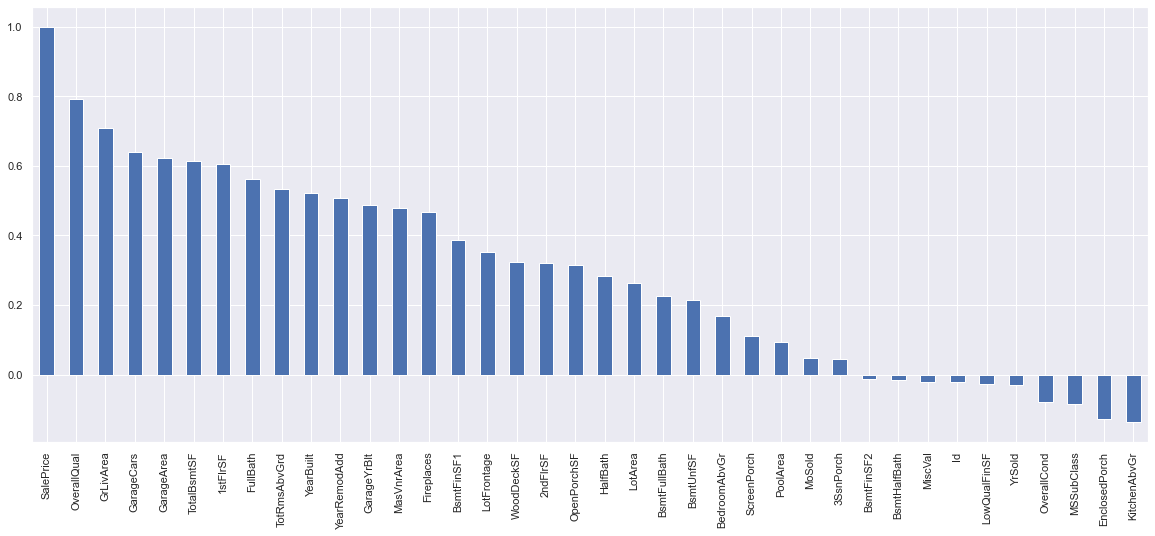

In [68]:
# SalePrice分析
# 获取“SalePrice”与其他变量的相关性:
plt.figure(figsize=(20,8))
train.corr()['SalePrice'].sort_values(ascending = False).plot(kind='bar')
# 由上图可以发现有10个变量与因变量的相关性大于0.5
# OverallQual 房屋设施的完整性
# GrLivArea 居住面积
# GarageCars  车库
# GarageArea  车库面积
# TotalBsmtSF 地下室大小
# 1stFlrSF 1楼面积
# FullBath 厕所面积
# TotRmsAbvGrd 地面上的房间数量
# YearBuilt 建造年份
# YearRemodAdd 重建年份

<AxesSubplot:>

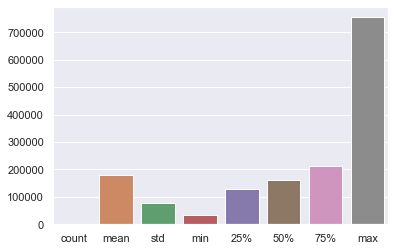

In [69]:
salePrice_analyse = train['SalePrice'].describe()
salePrice_analyse = {"groups" : salePrice_analyse.index,"values" : salePrice_analyse.values}
sns.barplot(x="groups",y = "values", data=salePrice_analyse)

<AxesSubplot:>

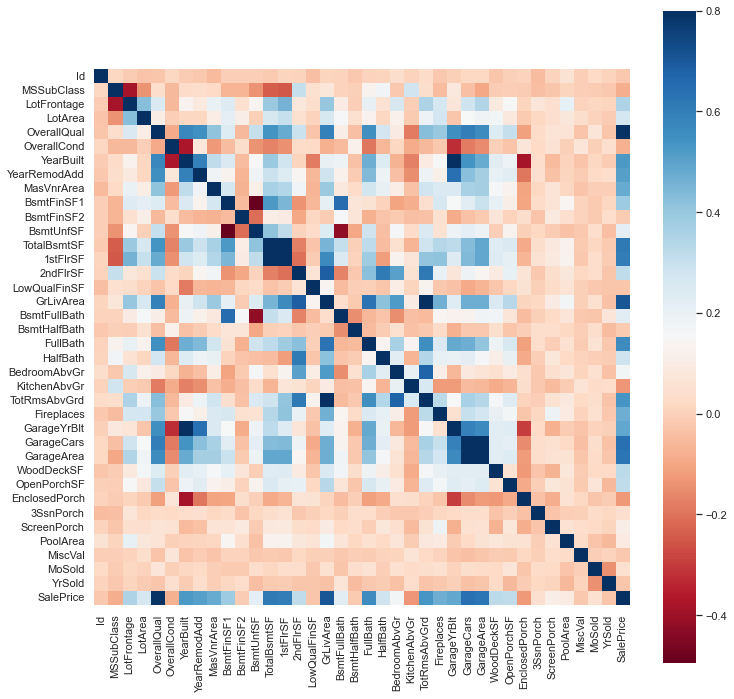

In [70]:
# 查看SalePrice与其他变量相关性
plt.figure(figsize=(12, 12))
train_corr = train.corr()
sns.heatmap(train_corr, square=True, vmax=0.8, cmap='RdBu')

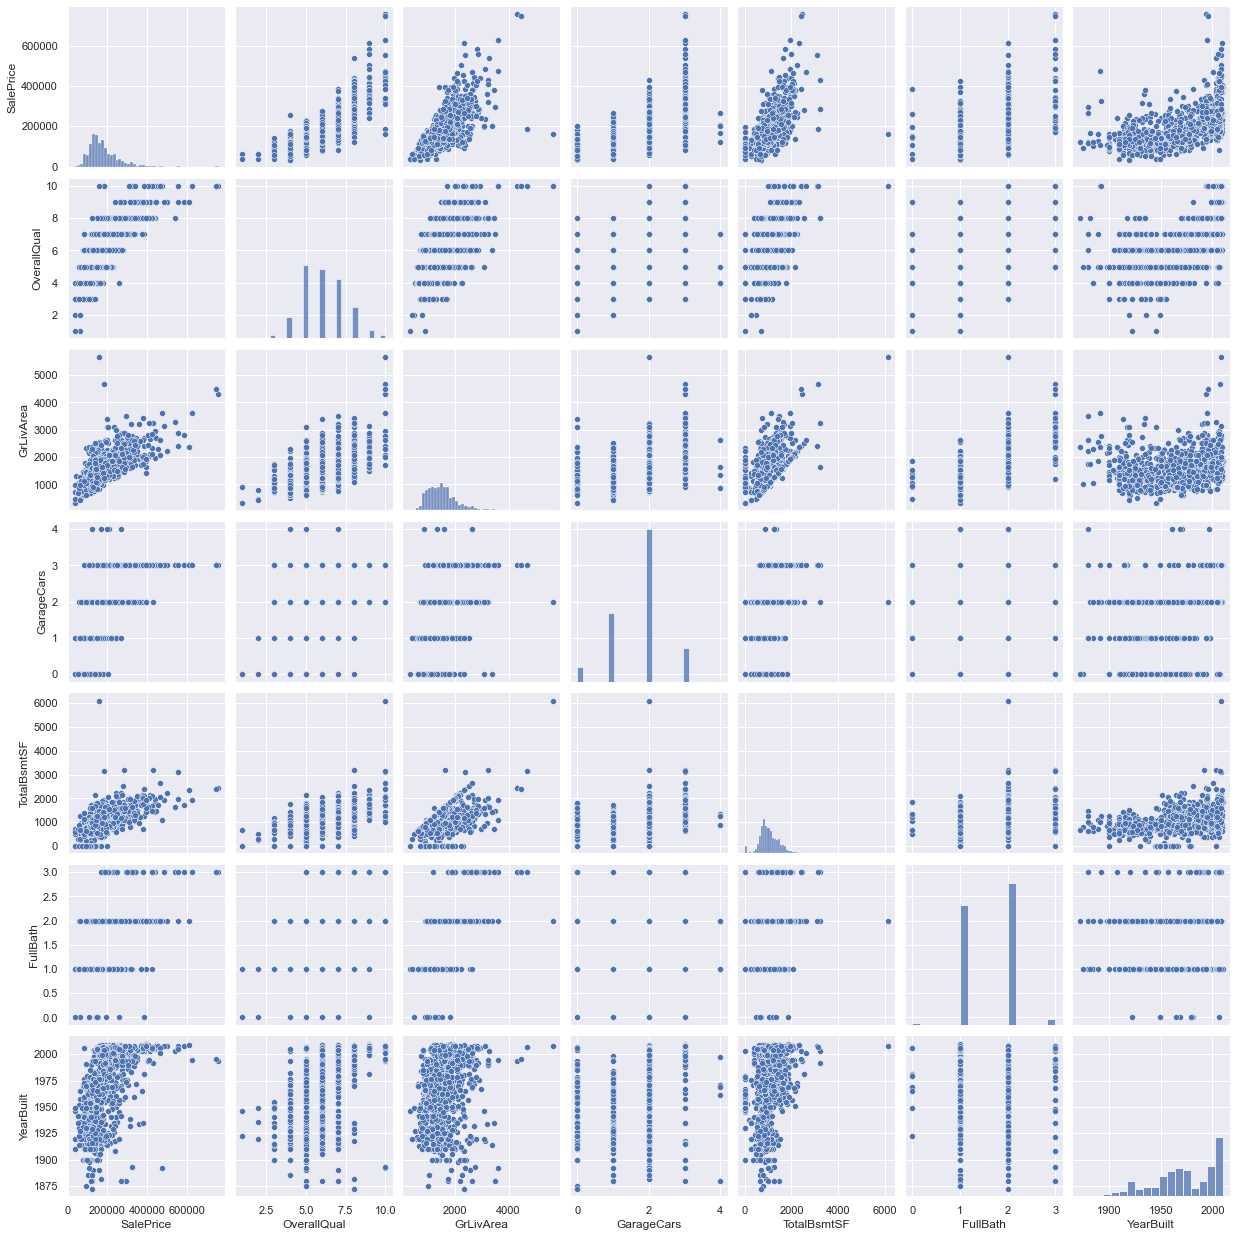

In [71]:
# 变量相关性查看
sns.set()
cols = ['SalePrice', 'OverallQual', 'GrLivArea', 'GarageCars', 'TotalBsmtSF', 'FullBath', 'YearBuilt']
sns.pairplot(train[cols], height = 2.5)
plt.show();

In [72]:
# 数据清洗
# 1.1重复值检查和处理
train[train.duplicated().values == True]

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice


In [75]:
# 1.2重复值处理
train = train.drop_duplicates()
# 1.3检查重复值处理是否完毕
train[train.duplicated().values == True]

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice


In [76]:
# 2.缺失值处理
total = train.isnull().sum().sort_values(ascending=False)
percent = (train.isnull().sum()/train.isnull().count()).sort_values(ascending=False)
missing_data = pd.concat([total, percent], axis=1, keys=['Total', 'Percent'])
missing_data
missing_data.head(20)

,Total,Percent
PoolQC,1453,0.995205
MiscFeature,1406,0.963014
Alley,1369,0.937671
Fence,1179,0.807534
FireplaceQu,690,0.472603
LotFrontage,259,0.177397
GarageYrBlt,81,0.055479
GarageCond,81,0.055479
GarageType,81,0.055479
GarageFinish,81,0.055479


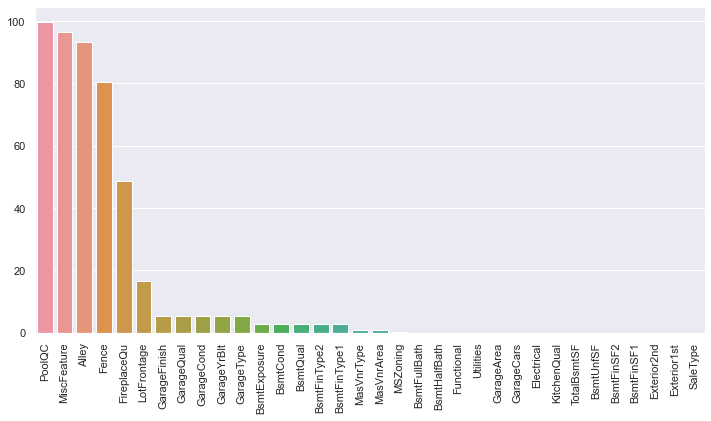

In [77]:
# 拼接数据并将缺失值数量可视化
all_data = pd.concat((train.drop(["SalePrice"], axis=1), test))
all_data_na = (all_data.isnull().sum() / len(all_data)) * 100
all_data_na = all_data_na.drop(all_data_na[all_data_na == 0].index).sort_values(ascending=False)
plt.figure(figsize=(12, 6))
plt.xticks(rotation="90")
sns.barplot(x=all_data_na.index, y=all_data_na)
plt.show()

In [78]:
# 填补缺失值，None\0\众数\中位数\指定值填充，或者去掉该列
for col in ('PoolQC', 'MiscFeature', 'Alley', 'Fence', 'FireplaceQu', 'GarageType', 'GarageFinish', 'GarageQual', 'GarageCond',
'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2', 'MasVnrType'):
   train[col].fillna("None", inplace=True)
for col in ('GarageYrBlt', 'GarageArea', 'GarageCars', 'BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', 'BsmtFullBath',
'BsmtHalfBath', 'MasVnrArea'):
   train[col].fillna(0, inplace=True)
for col in ('MSZoning', 'Electrical', 'KitchenQual', 'Exterior1st', 'Exterior2nd', 'SaleType', 'MSSubClass'):
   train[col].fillna(train[col].mode()[0], inplace=True)
train.drop(['Utilities'], axis=1, inplace=True)
# Functional : NA 意味着典型
all_data["Functional"] = all_data["Functional"].fillna("Typ")
train["LotFrontage"] = train.groupby("Neighborhood")["LotFrontage"].transform(
   lambda x: x.fillna(x.median()))

# 填补缺失值，None\0\众数\中位数\指定值填充，或者去掉该列
for col in ('PoolQC', 'MiscFeature', 'Alley', 'Fence', 'FireplaceQu', 'GarageType', 'GarageFinish', 'GarageQual', 'GarageCond',
'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2', 'MasVnrType'):
   test[col].fillna("None", inplace=True)
for col in ('GarageYrBlt', 'GarageArea', 'GarageCars', 'BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', 'BsmtFullBath',
'BsmtHalfBath', 'MasVnrArea'):
   test[col].fillna(0, inplace=True)
for col in ('MSZoning', 'Electrical', 'KitchenQual', 'Exterior1st', 'Exterior2nd', 'SaleType', 'MSSubClass'):
   test[col].fillna(test[col].mode()[0], inplace=True)
# Functional : NA 意味着典型
all_data["Functional"] = all_data["Functional"].fillna("Typ")
test.drop(['Utilities'], axis=1, inplace=True)
test["LotFrontage"] = test.groupby("Neighborhood")["LotFrontage"].transform(
   lambda x: x.fillna(x.median()))

<AxesSubplot:>

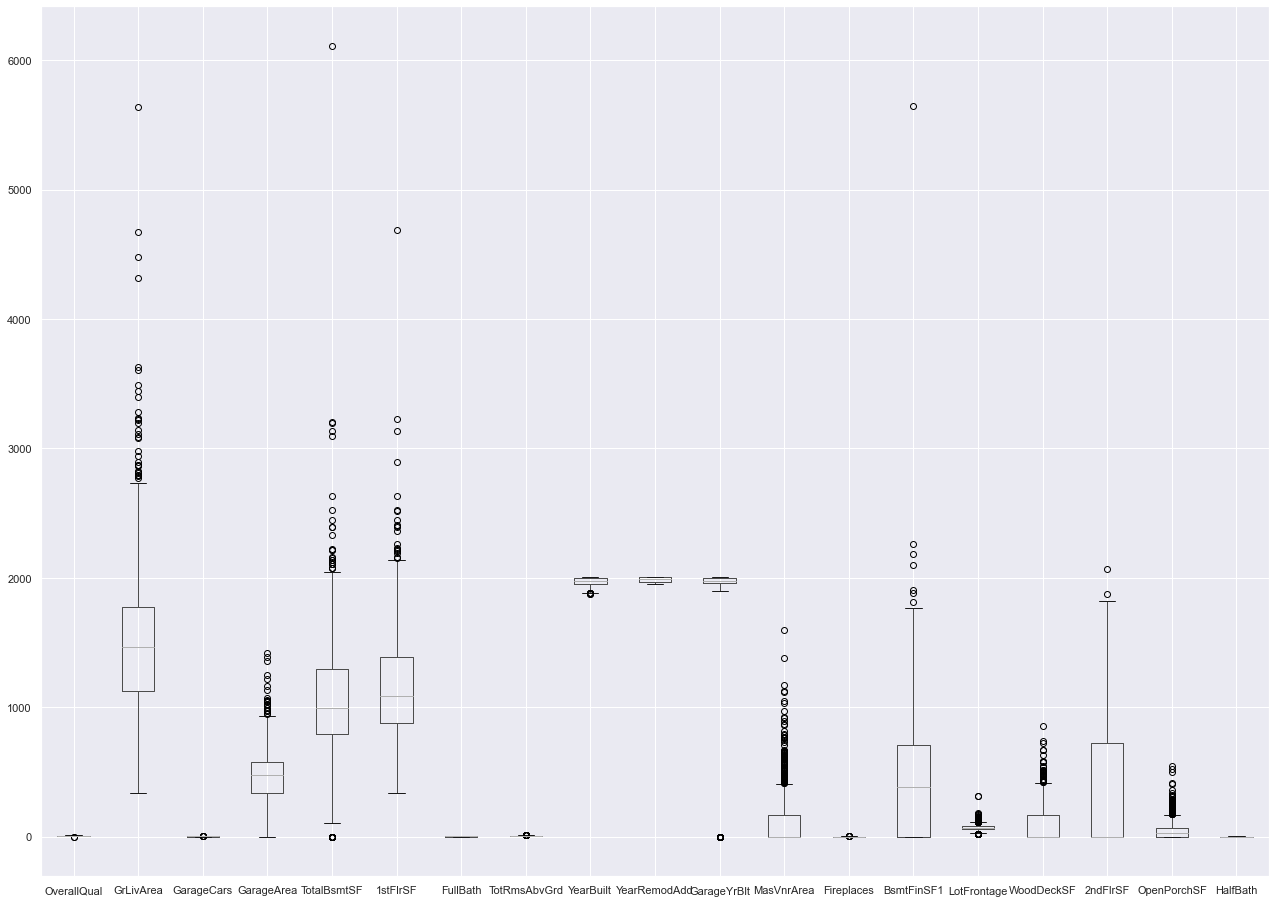

In [88]:
# 3.异常值处理
# 重点关注如下
# OverallQual 房屋设施的完整性
# GrLivArea 居住面积
# GarageCars  车库
# GarageArea  车库面积
# TotalBsmtSF 地下室大小
# 1stFlrSF 1楼面积
# FullBath 厕所面积
# TotRmsAbvGrd 地面上的房间数量
# YearBuilt 建造年份
# YearRemodAdd 重建年份
plt.figure(figsize=(22, 16))
train.boxplot(column=['OverallQual','GrLivArea','GarageCars','GarageArea','TotalBsmtSF','1stFlrSF','FullBath','TotRmsAbvGrd','YearBuilt','YearRemodAdd'
                     ,'GarageYrBlt','MasVnrArea','Fireplaces','BsmtFinSF1','LotFrontage','WoodDeckSF','2ndFlrSF','OpenPorchSF','HalfBath'
                     ])

<AxesSubplot:>

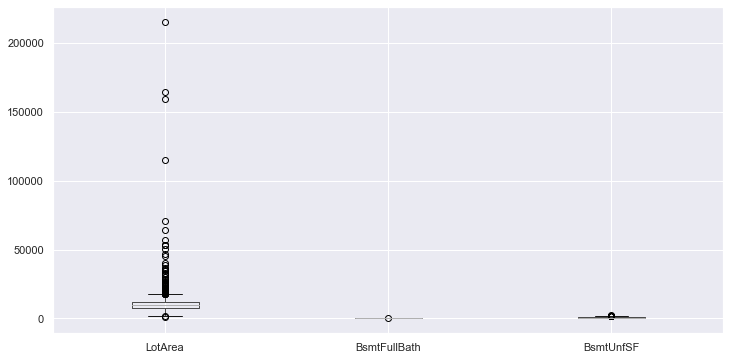

In [90]:
plt.figure(figsize=(12, 6))
train.boxplot(column=['LotArea','BsmtFullBath','BsmtUnfSF'])

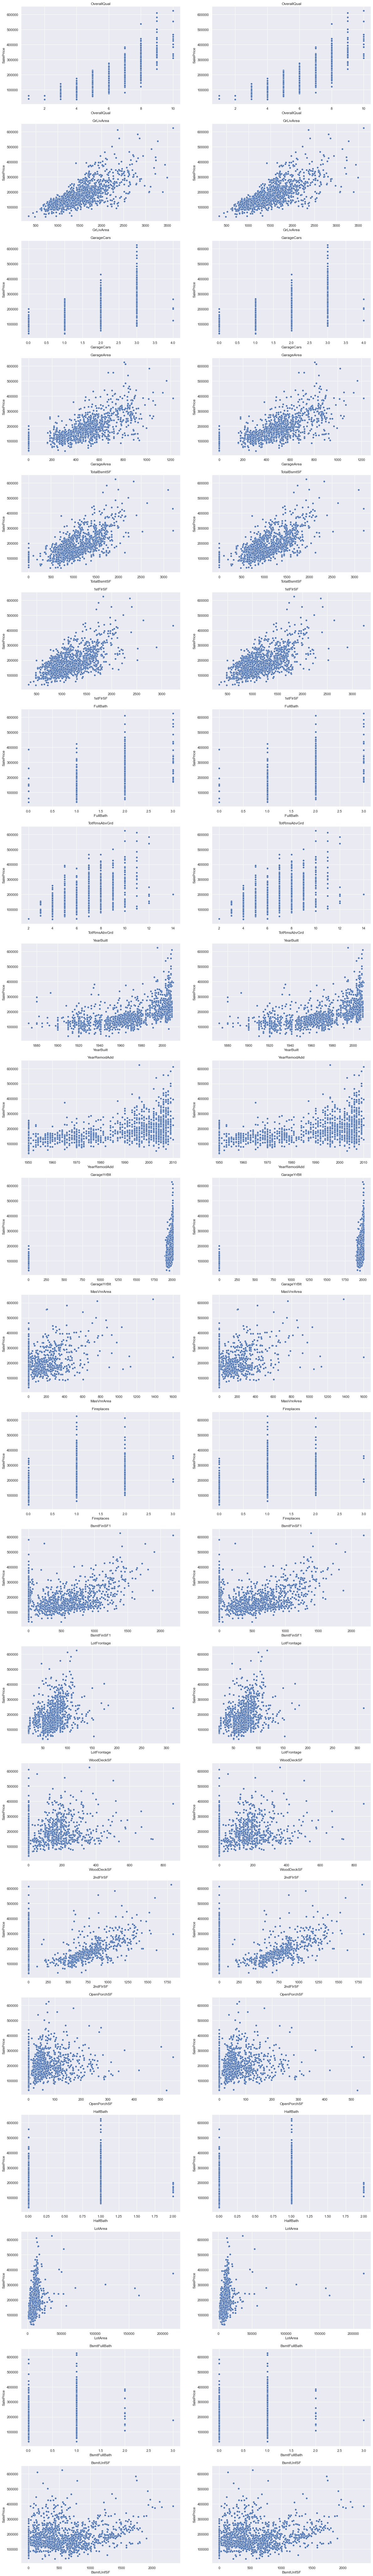

In [122]:
# 对房价有重要意义的变量
# 绘制散点图检查异常值点
colums = ['OverallQual','GrLivArea','GarageCars','GarageArea','TotalBsmtSF','1stFlrSF','FullBath','TotRmsAbvGrd','YearBuilt','YearRemodAdd'
                     ,'GarageYrBlt','MasVnrArea','Fireplaces','BsmtFinSF1','LotFrontage','WoodDeckSF','2ndFlrSF','OpenPorchSF','HalfBath'
                     ,'LotArea','BsmtFullBath','BsmtUnfSF']
figure,ax=plt.subplots(len(colums),2,figsize=(20,150))
index1 = 0
for item in colums:
    for index2 in [0,1]:
        ax[index1,index2].set_title(item)
        sns.scatterplot(x=train[item],y=train['SalePrice'],ax=ax[index1,index2])
        index2 = index2 + 1
    index1 = index1 + 1
# sns.scatterplot(x=train['OverallQual'],y=train['SalePrice'],ax=ax[0,0])
# sns.scatterplot(x=train['YearBuilt'],y=train['SalePrice'],ax=ax[0,1])
# sns.scatterplot(x=train['TotalBsmtSF'],y=train['SalePrice'],ax=ax[1,0])
# sns.scatterplot(x=train['GrLivArea'],y=train['SalePrice'],ax=ax[1,1])
# sns.scatterplot(x=train['GarageCars'],y=train['SalePrice'],ax=ax[2,0])
# sns.scatterplot(x=train['GarageArea'],y=train['SalePrice'],ax=ax[2,1])
# sns.scatterplot(x=train['TotalBsmtSF'],y=train['SalePrice'],ax=ax[3,0])
# sns.scatterplot(x=train['1stFlrSF'],y=train['SalePrice'],ax=ax[3,1])
# sns.scatterplot(x=train['FullBath'],y=train['SalePrice'],ax=ax[3,1])
# sns.scatterplot(x=train['TotRmsAbvGrd'],y=train['SalePrice'],ax=ax[3,1])
# sns.scatterplot(x=train['YearBuilt'],y=train['SalePrice'],ax=ax[3,1])
# sns.scatterplot(x=train['YearRemodAdd'],y=train['SalePrice'],ax=ax[3,1])
# sns.scatterplot(x=train['GarageYrBlt'],y=train['SalePrice'],ax=ax[3,1])
# sns.scatterplot(x=train['MasVnrArea'],y=train['SalePrice'],ax=ax[3,1])
# sns.scatterplot(x=train['Fireplaces'],y=train['SalePrice'],ax=ax[3,1])
# sns.scatterplot(x=train['1stFlrSF'],y=train['SalePrice'],ax=ax[3,1])
# sns.scatterplot(x=train['1stFlrSF'],y=train['SalePrice'],ax=ax[3,1])
# sns.scatterplot(x=train['1stFlrSF'],y=train['SalePrice'],ax=ax[3,1])

In [ ]:
#删除离群点
train.drop(train[(train['OverallQual']<5) & (train['SalePrice']>200000)].index,inplace=True)
train.drop(train[(train['YearBuilt']<1900) & (train['SalePrice']>400000)].index,inplace=True)
train.drop(train[(train['YearBuilt']>1980) & (train['SalePrice']>700000)].index,inplace=True)
train.drop(train[(train['TotalBsmtSF']>6000) & (train['SalePrice']<200000)].index,inplace=True)
train.drop(train[(train['GrLivArea']>4000) & (train['SalePrice']<200000)].index,inplace=True)
train.drop(train[(train['GarageArea']>1200) & (train['SalePrice']<300000)].index,inplace=True)

In [ ]:
# 4.
# 查看价格的分布情况
sns.distplot(train.SalePrice)

In [ ]:
res = stats.probplot(train['SalePrice'], plot=plt)

In [ ]:
# 将价格转为正态分布
train["SalePrice"] = np.log1p(train["SalePrice"])
sns.distplot(train.SalePrice)

In [ ]:
res = stats.probplot(train['SalePrice'], plot=plt)

In [ ]:
# 继续查看GrLivArea的情况
sns.distplot(train.GrLivArea)

In [ ]:
res = stats.probplot(train['GrLivArea'], plot=plt)

In [ ]:
# 将GrLivArea转为正态分布
# train["GrLivArea"] = np.log(train.GrLivArea + 1)
sns.distplot(train["GrLivArea"])

In [ ]:
res = stats.probplot(train['GrLivArea'], plot=plt)

In [ ]:
# 继续查看TotalBsmtSF的情况
sns.distplot(train["TotalBsmtSF"])

In [ ]:
stats.probplot(train['TotalBsmtSF'], plot=plt)

In [ ]:
# 数值型特征的数据变换：改变数据分布
numeric_df = all_data.select_dtypes(['int16','int32','int64','float16','float32','float64'])
numeric_cols = numeric_df.columns.tolist()
 
fig = plt.figure(figsize=(20, 30))
for col in numeric_cols:
    ax = fig.add_subplot(7, 8, numeric_cols.index(col)+1)
    ax.set_xlabel(col)
    ax.hist(numeric_df[col])

In [ ]:
# 计算各数值型特征的偏度
skewed_cols = all_data[numeric_cols].apply(lambda x: skew(x)).sort_values(ascending=False)
skewed_df = pd.DataFrame({'skew':skewed_cols})
skewed_df

In [ ]:
# 对偏度绝对值大于0.5的特征进行对数变换
skew_cols = skewed_df[skewed_df['skew'].abs()>1].index.tolist()
for col in skew_cols:
    all_data[col] = np.log1p(all_data[col])

In [ ]:
y = train["SalePrice"]

In [ ]:
# 构建新的特征
feature = pd.concat((train.drop(["SalePrice", "Id"], axis=1), test.drop(["Id"], axis=1)), axis=0)

#增加每个房屋的地下室，一楼和二楼的总面积特征
feature['TotalSF']=feature['TotalBsmtSF'] + feature['1stFlrSF'] + feature['2ndFlrSF']
# 新增房屋改造时间与房屋出售时间间隔
feature['YearsSinceRemodel'] = feature['YrSold'].astype(int) - feature['YearRemodAdd'].astype(int)
# 房间的整体质量
feature['Total_Home_Quality'] = feature['OverallQual'].astype(int) + feature['OverallCond'].astype(int)
# 开放式门廊、围廊、三季门廊、屏风玄关总面积
feature["PorchArea"] = feature["OpenPorchSF"]+feature["EnclosedPorch"]+ feature["3SsnPorch"]+feature["ScreenPorch"] +feature['WoodDeckSF']
feature['Total_Bathrooms'] = (feature['FullBath'] + (0.5 * feature['HalfBath']) +
                               feature['BsmtFullBath'] + (0.5 * feature['BsmtHalfBath']))
# 增添几个特征用于描述房屋内是否存在这些区域空间
feature['haspool'] = feature['PoolArea'].apply(lambda x: 1 if x > 0 else 0)
feature['has2ndfloor'] = feature['2ndFlrSF'].apply(lambda x: 1 if x > 0 else 0)
feature['hasgarage'] = feature['GarageArea'].apply(lambda x: 1 if x > 0 else 0)
feature['hasbsmt'] = feature['TotalBsmtSF'].apply(lambda x: 1 if x > 0 else 0)
feature['hasfireplace'] = feature['Fireplaces'].apply(lambda x: 1 if x > 0 else 0)

In [ ]:
train_dummies = pd.get_dummies(pd.concat((train.drop(["SalePrice", "Id"], axis=1), test.drop(["Id"], axis=1)), axis=0)).iloc[: train.shape[0]]
test_dummies = pd.get_dummies(pd.concat((train.drop(["SalePrice", "Id"], axis=1), test.drop(["Id"], axis=1)), axis=0)).iloc[train.shape[0]:]

In [ ]:
train_dummies

In [ ]:
# # 标准化-数据处理
# transfer = StandardScaler()
# train_dummies = pd.DataFrame(transfer.fit_transform(train_dummies))
# test_dummies = pd.DataFrame(transfer.fit_transform(test_dummies))

In [ ]:
# 借助Ridge寻找离群值
rr = Ridge(alpha=10)
rr.fit(train_dummies, y)
np.sqrt(-cross_val_score(rr, train_dummies, y, cv=5, scoring="neg_mean_squared_error")).mean()

In [ ]:
y_pred = rr.predict(train_dummies)
resid = y - y_pred
mean_resid = resid.mean()
std_resid = resid.std()
z = (resid - mean_resid) / std_resid
z = np.array(z)
outliers1 = np.where(abs(z) > abs(z).std() * 3)[0]
outliers1

In [ ]:
plt.figure(figsize=(6, 6))
plt.scatter(y, y_pred)
plt.scatter(y.iloc[outliers1], y_pred[outliers1])
plt.plot(range(10, 15), range(10, 15), color="red")
plt.show()

In [ ]:
# 借助ElasticNet探索离群值
er = ElasticNet(alpha=0.001, l1_ratio=0.58)
er.fit(train_dummies, y)
np.sqrt(-cross_val_score(rr, train_dummies, y, cv=5, scoring="neg_mean_squared_error")).mean()

In [ ]:
y_pred = er.predict(train_dummies)
resid = y - y_pred
mean_resid = resid.mean()
std_resid = resid.std()
z = (resid - mean_resid) / std_resid
z = np.array(z)
outliers2 = np.where(abs(z) > abs(z).std() * 3)[0]
outliers2

In [ ]:
plt.figure(figsize=(6, 6))
plt.scatter(y, y_pred)
plt.scatter(y.iloc[outliers2], y_pred[outliers2])
plt.plot(range(10, 15), range(10, 15), color="red")
plt.show()

In [ ]:
outliers = []
for i in outliers1:
    for j in outliers2:
        if i == j:
            outliers.append(i)
outliers

In [ ]:
# 删除离群点
# 将两次算法预测效果都不好的点作为离群值
train_dummies = train_dummies.drop([13,
 30,
 66,
 88,
 142,
 217,
 276,
 307,
 317,
 327,
 347,
 379,
 430,
 460,
 477,
 493,
 530,
 554,
 556,
 557,
 584,
 585,
 628,
 654,
 677,
 684,
 705,
 706,
 709,
 723,
 733,
 735,
 769,
 859,
 869,
 880,
 893,
 911,
 930,
 963,
 965,
 1056,
 1086,
 1116,
 1175,
 1315,
 1316,
 1335,
 1371,
 1374,
 1423,
 1444])
y = train["SalePrice"]
y = y.drop([13,
 30,
 66,
 88,
 142,
 217,
 276,
 307,
 317,
 327,
 347,
 379,
 430,
 460,
 477,
 493,
 530,
 554,
 556,
 557,
 584,
 585,
 628,
 654,
 677,
 684,
 705,
 706,
 709,
 723,
 733,
 735,
 769,
 859,
 869,
 880,
 893,
 911,
 930,
 963,
 965,
 1056,
 1086,
 1116,
 1175,
 1315,
 1316,
 1335,
 1371,
 1374,
 1423,
 1444])
train_dummies.shape,y.shape

In [ ]:
from sklearn.linear_model import LinearRegression
linearRegressionModel = LinearRegression()
X_train, X_test, y_train, y_test = train_test_split(train_dummies, y, test_size=0.3, random_state=101)
def try_different_method(model):
    model.fit(X_train,y_train)  # 拟合模型
    score = model.score(X_test, y_test)  # 模型评分
    result = model.predict(X_test)  # 测试集结果（目标变量）
#     测试集的均方根误差(真实目标变量与真实预测的目标变量比较)
    print('RMSE is: ', mean_squared_error(y_test, result))
    # 模型评分
    print('score is: ', score)
try_different_method(linearRegressionModel)

train_predict = linearRegressionModel.predict(X_train)

In [ ]:
plt.figure(figsize=(6, 6))
plt.scatter(y_train, train_predict)
plt.plot(range(10, 15), range(10, 15), color="red")
plt.show()

In [ ]:
test_predict = linearRegressionModel.predict(test_dummies)
pre_df = pd.DataFrame(test_predict)
pre_df["SalePrice"] = test_predict
pre_df = pre_df[["SalePrice"]]
test_predict = np.array(pre_df.SalePrice)
sample_submission["SalePrice"] = np.expm1(test_predict)
sample_submission.to_csv("/Users/ed/Downloads/house-prices-advanced-regression-techniques/submission.csv", index=False)

In [ ]:
# n_folds = 5
# def RMSE(alg):
#     kf = KFold(n_folds, shuffle=True, random_state=20).get_n_splits(X_train)
#     rmse= np.sqrt(-cross_val_score(alg, X_train, y_train, scoring="neg_mean_squared_error", cv = kf))
#     return(rmse)
# lasso = make_pipeline(RobustScaler(), Lasso(alpha =0.0005, random_state=1))
# score = RMSE(lasso)
# print("\nLasso score: {:.4f} ({:.4f})\n".format(score.mean(), score.std()))
# ENet = make_pipeline(RobustScaler(), ElasticNet(alpha=0.0005, l1_ratio=.9, random_state=3))
# score = RMSE(ENet)
# print("\nENet score: {:.4f} ({:.4f})\n".format(score.mean(), score.std()))
# KRR = KernelRidge(alpha=0.6, kernel='polynomial', degree=2, coef0=2.5)
# score = RMSE(KRR)
# print("\nKRR score: {:.4f} ({:.4f})\n".format(score.mean(), score.std()))
# GBoost = GradientBoostingRegressor(n_estimators=3000, learning_rate=0.05,
#                                    max_depth=4, max_features='sqrt',
#                                    min_samples_leaf=15, min_samples_split=10, 
#                                    loss='huber', random_state =5)
# score = RMSE(GBoost)
# print("\nGBoost score: {:.4f} ({:.4f})\n".format(score.mean(), score.std()))
# model_xgb = xgboost.XGBRegressor(colsample_bytree=0.4603, gamma=0.0468, 
#                              learning_rate=0.05, max_depth=3, 
#                              min_child_weight=1.7817, n_estimators=2200,
#                              reg_alpha=0.4640, reg_lambda=0.8571,
#                              subsample=0.5213, silent=1,
#                              random_state =7, nthread = -1)
# score = RMSE(model_xgb)
# print("\nXGBoost score: {:.4f} ({:.4f})\n".format(score.mean(), score.std()))
# model_lgb = lightgbm.LGBMRegressor(objective='regression',num_leaves=5,
#                               learning_rate=0.05, n_estimators=900,
#                               max_bin = 55, bagging_fraction = 0.8,
#                               bagging_freq = 5, feature_fraction = 0.8,
#                               min_data_in_leaf =6, min_sum_hessian_in_leaf = 11)
# score = RMSE(model_lgb)
# print("\nLGBoost score: {:.4f} ({:.4f})\n".format(score.mean(), score.std()))

n_folds = 5
def RMSE(alg):
    kf = KFold(n_folds, shuffle=True, random_state=20).get_n_splits(X_train)
    rmse= np.sqrt(-cross_val_score(alg, X_train, y_train, scoring="neg_mean_squared_error", cv = kf))
    return(rmse)
lasso = make_pipeline(RobustScaler(), Lasso(alpha =0.0005, random_state=1))
score_lasso = RMSE(lasso)
print("\nLasso score: {:.4f} ({:.4f})\n".format(score_lasso.mean(), score_lasso.std()))
ENet = make_pipeline(RobustScaler(), ElasticNet(alpha=0.0005, l1_ratio=.9, random_state=3))
score_ENet = RMSE(ENet)
print("\nENet score: {:.4f} ({:.4f})\n".format(score_ENet.mean(), score_ENet.std()))
KRR = KernelRidge(alpha=0.6, kernel='polynomial', degree=2, coef0=2.5)
score_KRR = RMSE(KRR)
print("\nKRR score: {:.4f} ({:.4f})\n".format(score_KRR.mean(), score_KRR.std()))
GBoost = GradientBoostingRegressor(n_estimators=3000, learning_rate=0.05,
                                   max_depth=4, max_features='sqrt',
                                   min_samples_leaf=15, min_samples_split=10, 
                                   loss='huber', random_state =5)
score_GBoost = RMSE(GBoost)
print("\nGBoost score: {:.4f} ({:.4f})\n".format(score_GBoost.mean(), score_GBoost.std()))
model_xgb = xgboost.XGBRegressor(colsample_bytree=0.4603, gamma=0.0468, 
                             learning_rate=0.05, max_depth=3, 
                             min_child_weight=1.7817, n_estimators=2200,
                             reg_alpha=0.4640, reg_lambda=0.8571,
                             subsample=0.5213, silent=1,
                             random_state =7, nthread = -1)
score = RMSE(model_xgb)
print("\nXGBoost score: {:.4f} ({:.4f})\n".format(score.mean(), score.std()))
model_lgb = lightgbm.LGBMRegressor(objective='regression',num_leaves=5,
                              learning_rate=0.05, n_estimators=720,
                              max_bin = 55, bagging_fraction = 0.8,
                              bagging_freq = 5, feature_fraction = 0.2319,
                              feature_fraction_seed=9, bagging_seed=9,
                              min_data_in_leaf =6, min_sum_hessian_in_leaf = 11)
score = RMSE(model_lgb)
print("\nLGBoost score: {:.4f} ({:.4f})\n".format(score.mean(), score.std()))

In [ ]:
X_train

In [ ]:
class AveragingModels(BaseEstimator, RegressorMixin, TransformerMixin):
    def __init__(self, models):
        self.models = models
        
    def fit(self, X, y):
        self.models_ = [clone(x) for x in self.models]
        
        for model in self.models_:
            model.fit(X, y)

        return self
    
    def predict(self, X):
        predictions = np.column_stack([
            model.predict(X) for model in self.models_
        ])
        return np.mean(predictions, axis=1)  
averaged_models = AveragingModels(models = (ENet, GBoost, KRR, lasso))

score = RMSE(averaged_models)
print(" Averaged base models score: {:.4f} ({:.4f})\n".format(score.mean(), score.std()))

In [ ]:
class StackingAveragedModels(BaseEstimator, RegressorMixin, TransformerMixin):
    def __init__(self, base_models, meta_model, n_folds=5):
        self.base_models = base_models
        self.meta_model = meta_model
        self.n_folds = n_folds
   
    def fit(self, X, y):
        self.base_models_ = [list() for x in self.base_models]
        self.meta_model_ = clone(self.meta_model)
        kfold = KFold(n_splits=self.n_folds, shuffle=True, random_state=42)
        
        out_of_fold_predictions = np.zeros((X.shape[0], len(self.base_models)))
        for i, model in enumerate(self.base_models):
            for train_index, holdout_index in kfold.split(X, y):
                instance = clone(model)
                self.base_models_[i].append(instance)
                instance.fit(X.iloc[train_index], y.iloc[train_index])
                y_pred = instance.predict(X.iloc[holdout_index])
                out_of_fold_predictions[holdout_index, i] = y_pred
                
        self.meta_model_.fit(out_of_fold_predictions, y)
        return self
   
    def predict(self, X):
        meta_features = np.column_stack([
            np.column_stack([model.predict(X) for model in base_models]).mean(axis=1)
            for base_models in self.base_models_ ])
        return self.meta_model_.predict(meta_features)
stacked_averaged_models = StackingAveragedModels(base_models = (ENet, GBoost, KRR),
                                                 meta_model = lasso)

score = RMSE(stacked_averaged_models)
print("Stacking Averaged models score: {:.4f} ({:.4f})".format(score.mean(), score.std()))

In [ ]:
model_fit = stacked_averaged_models.fit(X_train, y_train)
result = np.expm1(stacked_averaged_models.predict(test_dummies)) # log(1+x)逆运算

In [ ]:
def rmsle(y, y_pred):
    return np.sqrt(mean_squared_error(y, y_pred))

In [ ]:
stacked_averaged_models.fit(X_train, y_train)
stacked_train_pred = stacked_averaged_models.predict(X_train)
stacked_pred = np.expm1(stacked_averaged_models.predict(test_dummies))
print(rmsle(y_train, stacked_train_pred))

In [ ]:
model_xgb.fit(X_train, y_train)
xgb_train_pred = model_xgb.predict(X_train)
xgb_pred = np.expm1(model_xgb.predict(test_dummies))
print(rmsle(y_train, xgb_train_pred))

In [ ]:
model_lgb.fit(X_train, y_train)
lgb_train_pred = model_lgb.predict(X_train)
lgb_pred = np.expm1(model_lgb.predict(test_dummies))
print(rmsle(y_train, lgb_train_pred))

In [ ]:
print('RMSLE score on train data:')
print(rmsle(y_train,stacked_train_pred*0.30 +
               xgb_train_pred*0.2 + lgb_train_pred*0.5 ))

In [ ]:
ensemble = stacked_pred*0.30 + xgb_pred*0.20 + lgb_pred*0.50

In [ ]:
# 保存预测结果
submission = pd.DataFrame()
submission['Id'] = sample_submission['Id']
submission['SalePrice'] = ensemble
submission.to_csv('/Users/ed/Downloads/house-prices-advanced-regression-techniques/submission2.csv',index=False)

In [ ]:
# #决策树可视化
# from sklearn.tree import export_graphviz
# export_graphviz(model_lgb, out_file="tree.dot", 
#                          feature_names=train_dummies.columns[0:],  
#                          class_names=train.SalePrice,  
#                          filled=True, rounded=True, special_characters=True)  
# with open("tree.dot") as f:
#     dot_graph=f.read()
#     graph=graphviz.Source(dot_graph)
# model_xgb.fit(train_dummies,y)
# xgboost.to_graphviz(model_xgb, num_trees=1)

In [ ]:
model_score_array = {"groups":["Lasso","ENet","KRR","GBoost","stacking","XGBoost","LightGBM","Weight allocation"],"values":[score_lasso.mean(),score_ENet.mean(),score_KRR.mean(),score_GBoost.mean(),rmsle(y_train, stacked_train_pred),rmsle(y_train, xgb_train_pred),rmsle(y_train, lgb_train_pred),rmsle(y_train,stacked_train_pred*0.30 +
               xgb_train_pred*0.2 + lgb_train_pred*0.5 )]}
model_score = pd.DataFrame(model_score_array)
plt.figure(figsize=(10, 7))
sns.lineplot(x = "groups",y="values", data=model_score)